## RL State Space Engineering: Clustering Health Regimes
To enable tractable reinforcement learning for RUL aware decision making, we discretize the high dimensional continuous sensor space into a small number of **interpretable health regimes**.   Rather than exposing raw sensor signals to the agent, we construct a compact state representation that captures the engine’s degradation stage.

### 1. Data Preparation

The C-MAPSS FD001 dataset is processed by computing the Remaining Useful Life (RUL) for each engine cycle. Operating settings and known constant sensors are removed, leaving only informative sensor measurements for state construction.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gymnasium as gym
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import joblib
import os

CLUSTER_COUNT = 4  # Healthy, Degraded, Warning, Critical
SEED = 405
np.random.seed(SEED)


In [2]:
data_path = '../data/raw/nasa-cmaps/CMaps/'
col_names = ['unit_number', 'time_cycles', 'setting_1', 'setting_2', 'setting_3'] + [f's_{i}' for i in range(1, 22)]

train_df = pd.read_csv(data_path + 'train_FD001.txt', sep='\s+', header=None, names=col_names)

max_cycle = train_df.groupby('unit_number')['time_cycles'].max().reset_index()
max_cycle.columns = ['unit_number', 'max_life']
train_df = train_df.merge(max_cycle, on='unit_number', how='left')
train_df['RUL'] = train_df['max_life'] - train_df['time_cycles']
train_df.drop(columns=['max_life'], inplace=True)

drop_cols = ['setting_1', 'setting_2', 'setting_3','s_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

train_df_clean = train_df.drop(columns=drop_cols)
train_df_clean.shape


(20631, 17)

### 2. Health Regime Clustering

We apply **K-Means clustering** to group similar sensor patterns into four discrete health regimes:  
**Healthy, Degraded, Warning, and Critical**. Since cluster labels are assigned arbitrarily, clusters are reordered based on their mean RUL such that:
- **Cluster 0** corresponds to the lowest RUL (critical condition)
- **Cluster 3** corresponds to the highest RUL (healthy operation)


In [3]:
cluster_features = [c for c in train_df_clean.columns if c not in ['unit_number', 'time_cycles', 'RUL']]

scaler_cluster = StandardScaler()
X_cluster = scaler_cluster.fit_transform(train_df_clean[cluster_features])
kmeans = KMeans(n_clusters=CLUSTER_COUNT, random_state=SEED, n_init=10)
clusters = kmeans.fit_predict(X_cluster)

cluster_map = pd.DataFrame({'cluster': clusters, 'RUL': train_df_clean['RUL']})
rul_means = cluster_map.groupby('cluster')['RUL'].mean().sort_values()
mapping = {old: new for new, old in enumerate(rul_means.index)}
sorted_clusters = np.array([mapping[c] for c in clusters])

train_df_clean['cluster'] = sorted_clusters

### 3. Latent Space Visualization

Sensor data is projected into two dimensions using **Principal Component Analysis (PCA)** to qualitatively validate the clustering. A smooth gradient across clusters in the PCA space indicates alignment with the degradation trajectory.

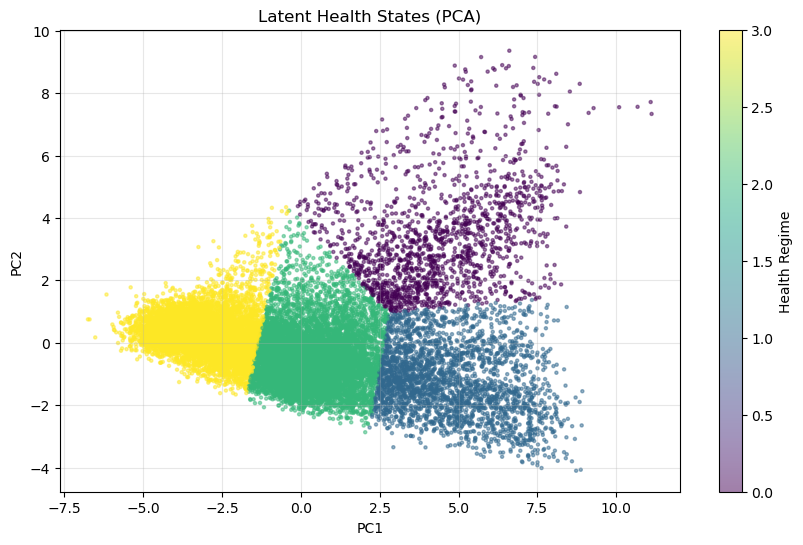

In [4]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_cluster)

plt.figure(figsize=(10, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=sorted_clusters, cmap='viridis', s=5, alpha=0.5)
plt.colorbar(label='Health Regime')
plt.title('Latent Health States (PCA)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True, alpha=0.3)
plt.show()

### 4. Validation via RUL Distribution

The RUL distribution within each cluster exhibits a monotonic trend, confirming that the identified regimes correspond to meaningful degradation stages.

/var/folders/25/m49ymdvs1k9fzs7p330mzdph0000gn/T/ipykernel_8274/1103876351.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='cluster', y='RUL', data=train_df_clean, palette='viridis')


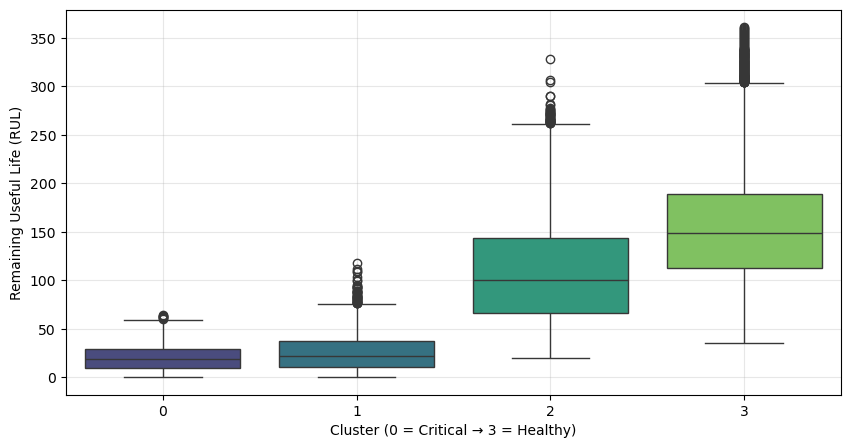

In [5]:
plt.figure(figsize=(10, 5))
sns.boxplot(x='cluster', y='RUL', data=train_df_clean, palette='viridis')
plt.xlabel('Cluster (0 = Critical → 3 = Healthy)')
plt.ylabel('Remaining Useful Life (RUL)')
plt.grid(True, alpha=0.3)
plt.show()

### 5. Saving
The fitted scaler, clustering model, and label mapping are saved and reused inside the RL environment to ensure consistent and deterministic state assignment during simulation.

In [6]:
models_dir = '../models/'
os.makedirs(models_dir, exist_ok=True)

joblib.dump(scaler_cluster, f'{models_dir}/scaler_cluster.pkl')
joblib.dump(kmeans, f'{models_dir}/kmeans_model.pkl')
joblib.dump(mapping, f'{models_dir}/cluster_mapping.pkl')

['../models//cluster_mapping.pkl']